In [14]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing

In [3]:
df = pd.read_csv("engineered_nyc_2.csv")
df.head()

,Fiscal_Year,Borough,Award,Council_District_num,Sector,Category
0,2019,X,250000,16.0,Housing & Dev,Community/Housing
1,2019,K,3640000,37.0,Health & Human Svcs,"Education, Infrastructure/Renovation"
2,2019,M,425000,5.0,Education,"Education, Infrastructure/Renovation"
3,2019,M,100000,5.0,Education,"Education, Infrastructure/Renovation, Parks & ..."
4,2019,M,35000,5.0,Education,"Education, Infrastructure/Renovation, Technology"


In [4]:
df.isna().sum()

Fiscal_Year              0
Borough                  0
Award                    0
Council_District_num    26
Sector                   0
Category                 0
dtype: int64

In [5]:
df["Council_District_num"] = df["Council_District_num"].fillna("No_District")
#check
df.isna().sum()

Fiscal_Year             0
Borough                 0
Award                   0
Council_District_num    0
Sector                  0
Category                0
dtype: int64

In [6]:
df["log_Awards"] = np.log1p(df["Award"])
df.head()

,Fiscal_Year,Borough,Award,Council_District_num,Sector,Category,log_Awards
0,2019,X,250000,16.0,Housing & Dev,Community/Housing,12.429220
1,2019,K,3640000,37.0,Health & Human Svcs,"Education, Infrastructure/Renovation",15.107495
2,2019,M,425000,5.0,Education,"Education, Infrastructure/Renovation",12.959847
3,2019,M,100000,5.0,Education,"Education, Infrastructure/Renovation, Parks & ...",11.512935
4,2019,M,35000,5.0,Education,"Education, Infrastructure/Renovation, Technology",10.463132


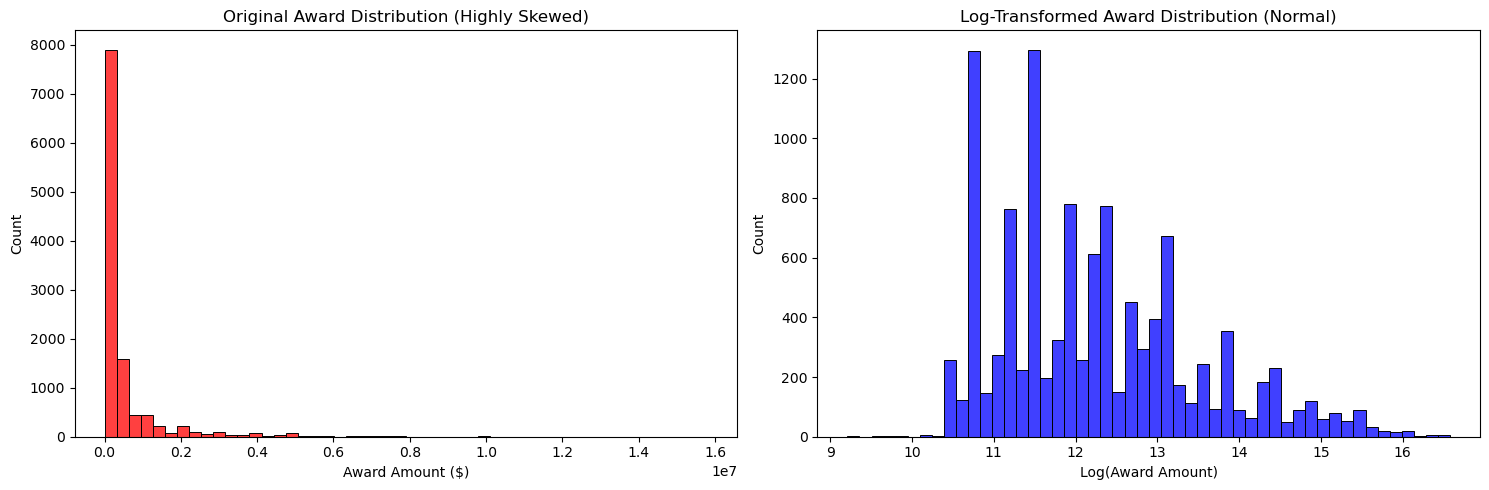

In [7]:
#plotting before vs after log transformation

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Original Skewed Data
sns.histplot(df['Award'], bins=50, ax=axes[0], color='red')
axes[0].set_title('Original Award Distribution (Highly Skewed)')
axes[0].set_xlabel('Award Amount ($)')

# Plot 2: Log-Transformed Data
sns.histplot(df['log_Awards'], bins=50, ax=axes[1], color='blue')
axes[1].set_title('Log-Transformed Award Distribution (Normal)')
axes[1].set_xlabel('Log(Award Amount)')

plt.tight_layout()
plt.show()

____________________________________________________________________________________________________________________________________________________________
Simple Linear Regression (From Scratch vs Library)

Either way, the results will be bad...but let's compare anyway!

In [ ]:
y = df[["log_Awards"]] #target
#Case 1: Fiscal Year - the only case of using Simple Linear Regression after dataset has been cleaned and engineered.
X_year = df[['Fiscal_Year']]

From Scratch:

In [9]:
class UpdatedLinearRegressionScratch:

    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.coef_ = None
        self.intercept_ = None
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        m, n_features = X.shape
        
        # 1. Initialize weights to zeros
        self.coef_ = np.zeros((n_features, 1))
        self.intercept_ = 0.0

        for _ in range(self.n_iterations):
            # Calculate the predictions
            y_pred = self.predict(X)

            # 2. Compute the RESIDUALS (Derivative base)
            residuals = y_pred - y  

            # 3. Calculate the gradients correctly
            # Derivative of MSE with respect to intercept
            intercept_gradient = (2/m) * np.sum(residuals)
            
            # Derivative of MSE with respect to coefficients
            coef_gradient = (2/m) * np.dot(X.T, residuals)

            # 4. Update the parameters
            self.intercept_ -= self.learning_rate * intercept_gradient
            self.coef_ -= self.learning_rate * coef_gradient

    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_
    
    def R_squared(self, y_true, y_pred):
        SSres = np.sum((y_true - y_pred)**2)
        SStot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - (SSres/SStot)
    
    def MAE(self, y_true, y_pred):
        n = len(y_true)
        return (np.sum(np.abs(y_true - y_pred))) / n
    
    def MSE(self, y_true, y_pred):
        n = len(y_true)
        return (np.sum((y_true - y_pred)**2)) / n

# Standardize the year before fitting
years_scaled = (X_year.values - np.mean(X_year.values)) / np.std(X_year.values)
years_reshape = years_scaled.reshape(-1, 1)

award_reshape = y.values.reshape(-1, 1)

# Now it will learn properly
lr = 0.01
n_iter = 1000 # 10 is usually too small for gradient descent
lin_reg_updated = UpdatedLinearRegressionScratch(learning_rate=lr, n_iterations=n_iter)
lin_reg_updated.fit(years_reshape, award_reshape)

print(f"Intercept : {lin_reg_updated.intercept_}")
print(f"Coef : {lin_reg_updated.coef_[0][0]}")

predicted_log_awards = lin_reg_updated.predict(years_reshape)

#Evaluation Metrics
r2 = lin_reg_updated.R_squared(y.values, predicted_log_awards)
mse = lin_reg_updated.MSE(y.values, predicted_log_awards)
mae = lin_reg_updated.MAE(y.values, predicted_log_awards)

print(f'R^2: {r2}, MSE: {mse}, MAE: {mae}')

Intercept : 12.256682015352471
Coef : 0.1549871951034947
R^2: 0.01605237700597939, MSE: 1.4723947784678182, MAE: 0.9807551293137133


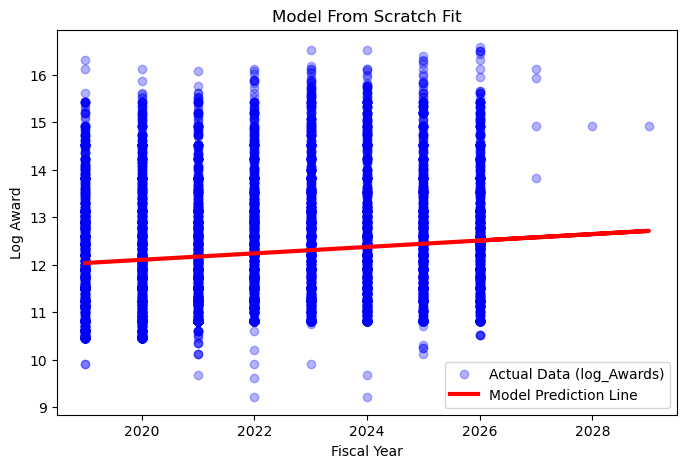

In [10]:
plt.figure(figsize=(8, 5))
# Plot the actual data points
plt.scatter(X_year, award_reshape, color='blue', alpha=0.3, label='Actual Data (log_Awards)')
# Plot the line of best fit that your model learned
plt.plot(X_year, predicted_log_awards, color='red', linewidth=3, label='Model Prediction Line')

plt.title("Model From Scratch Fit")
plt.xlabel("Fiscal Year")
plt.ylabel("Log Award")
plt.legend()
plt.show()

Using sklearn library:

In [11]:
model = LinearRegression()
reg = model.fit(years_reshape,y)
y_pred = reg.predict(years_reshape)
    
mse_lib = mean_squared_error(y, y_pred)
mae_lib = mean_absolute_error(y, y_pred)
r2_lib = r2_score(y, y_pred)

intercept = reg.intercept_
coefficient = reg.coef_

# print(type(intercept))
# print(type(coefficient))

print(f'Intercept : {intercept.ravel()[0]}')
print(f'Coef : {coefficient.ravel()[0]}')
print(f'R^2: {r2_lib}, MSE: {mse_lib}, MAE: {mae_lib}')

Intercept : 12.256682035980067
Coef : 0.15498719536433606
R^2: 0.016052377005979834, MSE: 1.4723947784678175, MAE: 0.9807551322338256


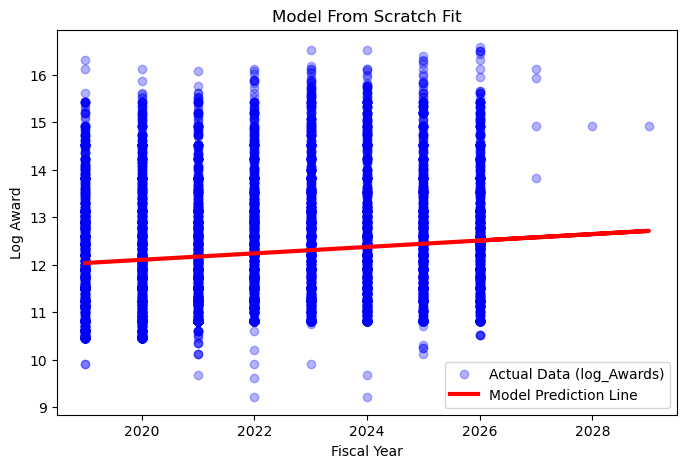

In [12]:
plt.figure(figsize=(8, 5))
plt.scatter(X_year, award_reshape, color='blue', alpha=0.3, label='Actual Data (log_Awards)')
plt.plot(X_year, y_pred, color='red', linewidth=3, label='Model Prediction Line')

plt.title("Model From Scratch Fit")
plt.xlabel("Fiscal Year")
plt.ylabel("Log Award")
plt.legend()
plt.show()

Both perform...horribly, as expected, but both versions have similar results.

______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Multiple Linear Regression:
Source: https://www.geeksforgeeks.org/machine-learning/multiple-linear-regression-with-scikit-learn/

In [ ]:
# df = pd.read_csv('engineered_nyc.csv')

# df["log_Awards"] = np.log1p(df["Award"])
# df.head()

# X = df.drop(columns=['Award', 'log_Awards'], axis = 1)
# y = df['log_Awards']
# print(X)
# print(y)

In [ ]:
# # Assuming X contains your dummy columns
# sector_cols = [col for col in X.columns if col.startswith('Sector')]
# sector_counts = X[sector_cols].sum().sort_values(ascending=False)
# print(sector_counts)

# # Plotting the sums
# sector_counts.plot(kind='barh', title='Number of Projects per Sector')

______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Multiple Linear Regression from Scratch:

In [29]:
#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Calculate medians using ONLY the training data
# We temporarily attach y_train to X_train to do the group by
train_data = X_train.copy()
train_data['Award'] = y_train

category_medians = train_data.groupby('Category')['Award'].median()
sector_medians = train_data.groupby('Sector')['Award'].median()
fiscalyear_medians = train_data.groupby('Fiscal_Year')['Award'].median()

# 3. Map these back to X_train and X_test
X_train['Median_Award_Category'] = X_train['Category'].map(category_medians)
X_test['Median_Award_Category'] = X_test['Category'].map(category_medians)

X_train['Median_Award_Sector'] = X_train['Sector'].map(sector_medians)
X_test['Median_Award_Sector'] = X_test['Sector'].map(sector_medians)

X_train['Median_Award_FiscalYear'] = X_train['FiscalYear'].map(sector_medians)
X_test['Median_Award_FiscalYear'] = X_test['FiscalYear'].map(sector_medians)

# 4. Fill missing values
# If a category exists in the Test set but wasn't in the Train set, it will be NaN.
# Fill it with the global median of the training set.
X_train.fillna(y_train.median(), inplace=True)
X_test.fillna(y_train.median(), inplace=True)

KeyError: 'Category'